In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from tqdm import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset,DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()


True

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [3]:
class BPETokenizer:
    def __init__(self,max_vocab = 284):
        self.max_vocab = max_vocab
        self.vocab = {idx:bytes([idx]) for idx in range(256)}
        self.merges = {} # trackes the merges ((token1,token2),token3)
    def fit(self,corpus):
        """ 
        fits the BPE tokenizer on a given corpus (strings)
        """
        if not corpus:
            raise ValueError("Corpus must not be empty.")
        tokens = corpus.encode("utf-8") # convert to byte-level tokens 
        ids = list(map(int,tokens))
        num_merges = self.max_vocab - 256 
        for i in range(num_merges):
            stats = self.get_stats(ids)
            pair = max(stats,key= stats.get) # Most frequent pair
            idx = 256 + i
            # print(f"merging {pair} into a new token {idx}")
            ids = self.merge(ids,pair,idx)
            self.merges[pair] = idx # add merge data to the dic 
            self.vocab[idx] = self.vocab[pair[0]] + self.vocab[pair[1]]
        return ids
    def encode(self,text):
        """ 
        input -:a text string.
        output -: List of token IDs."""
        tokens = list(text.encode('utf-8'))
        while len(tokens) >= 2:
            stats = self.get_stats(tokens)
            pair = min(stats,key=lambda p:self.merges.get(p,float('inf')))
            if pair not in self.merges:
                break # no more merges possible 
            idx = self.merges[pair]
            tokens = self.merge(tokens,pair,idx)
        return tokens
    def decode(self,ids):
        tokens = b"".join(self.vocab[idx] for idx in ids)
        text = tokens.decode("utf-8",errors="ignore")
        return text        
    def get_stats(self,ids):
        counts = {}
        for pair in zip(ids,ids[1:]):
            counts[pair] = counts.get(pair,0) + 1
        return counts
    def merge(self,ids,pair,idx):
        new_ids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i + 1] == pair[1]:
                new_ids.append(idx) # append new id of the pair
                i += 2
            else:
                new_ids.append(ids[i])
                i += 1
        return new_ids
    
            
        
        
        
    

In [4]:
class BPETokenizer1:
    """ 
    BPETokenizer1 is a variant to BPE tokenizer 
    with a custom character-to-integer encoding scheme"""
    def __init__(self,max_vocab = 86):
        self.max_vocab = max_vocab
        self.vocab = {} # Maps integer to char/strings
        self.stoi = {} # Maps char/strings back to integer
        self.merges = {}
    def fit(self,corpus):
        """ 
        Fits the tokenizer on a given corpus : string
        """
        if not corpus:
            raise ValueError("Corpus must not empty.")
        self.uniqueID = list(sorted(set(corpus))) # list of unique chars
        self.default_len = len(self.uniqueID)
        print(f"unique ids in corpus : {len(self.uniqueID)}") 
        self.vocab = {idx:ch for idx,ch in enumerate(self.uniqueID)}
        self.stoi = {ch:idx for idx,ch in enumerate(self.uniqueID)}
        # Initial Token un-prepocessed 
        ids = [self.stoi[ch] for ch in corpus]
        
        num_merges = self.max_vocab - len(self.vocab)
        for i in range(num_merges):
            stats = self._get_stats(ids)
            if not stats:
                break
            pair = max(stats,key=stats.get) # Most frequent pair
            idx = i + self.default_len
            
            # Merge the pair into a new token
            ids = self._merge(ids,pair,idx)
            self.merges[pair] = idx
            self.vocab[idx] = self.vocab[pair[0]] + self.vocab[pair[1]]
        return ids
    def encode(self,txt):
        """ 
        returns a List of token IDs
        input : txt(string)
        output : List
        """
        tokens = [self.stoi[ch] for ch in txt]
        while len(tokens) >=2:
            stats = self._get_stats(tokens)
            pair = min(stats,key=lambda p:self.merges.get(p,float('inf')))
            if pair not in self.merges:
                break #No more merges possible
            idx = self.merges[pair]
            tokens = self._merge(tokens,pair,idx)
        return tokens
            
    def decode(self,ids):
        """ 
        input : List of tokens 
        output : string
        """
        tokens = ''.join(self.vocab[idx] for idx in ids)
        return tokens
        
    def _get_stats(self,ids):
        """ 
        tracks the frequency of each adj pair of tokens
        """
        counts ={}
        for pair in zip(ids,ids[1:]):
            counts[pair] = counts.get(pair,0) + 1
        return counts 
    def _merge(self,ids,pair,idx):
        """ 
        ids is the list of Tokens 
        pair is the one which has to be replaced by token - idx
        """
        new_ids = []
        i = 0
        while i <len(ids):
            if i <len(ids) - 1 and ids[i] == pair[0] and ids[i + 1] == pair[1]:
                new_ids.append(idx)
                i += 2
            else:
                new_ids.append(ids[i])
                i += 1
        return new_ids
        
        
        
            

In [5]:
# text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
# Toknizer = BPETokenizer1(100)
# Toknizer.fit(text)
# Toknizer.vocab


In [6]:
# Toknizer.merges

In [7]:
# Toknizer.encode("helloing worstlthd!")

In [8]:
# print(Toknizer.decode(Toknizer.encode(text)))

In [9]:
@dataclass
class config:
    batch_size :int = 1032
    embd_size :int = 32
    block_size :int = 200
    vocab_size :int = 86
    a_size :int = 256
    c_size :int = 256

@dataclass
class config2:
    batch_size :int = 512
    embd_size :int = 256
    block_size :int = 254
    vocab_size :int = 284
    a_size :int = 512
    c_size :int = 512


In [10]:
class CustomDataset(Dataset):
    def __init__(self,Tokenizer,filepath = '.../input.text',overlap_ratio = 0.1):
        """ 
        overlap_ratio --> overlap between two sequences 
        what part of the previous sequence is passed on to the next sequence of words. 
        This will also allow us shuffling too.
        """
        super().__init__()
        if filepath is None:
            raise ValueError("filepath can't be empty.")
        self.filepath = filepath
        self.Tokenizer = Tokenizer
        self.config = config
        self.overlap_ratio = overlap_ratio
        with open(self.filepath,'r',encoding='utf-8') as f:
            corpus = str(f.read())
            
        self.Tokens = torch.tensor(self.Tokenizer.fit(corpus))
        step = int(self.config.block_size*(1 - self.overlap_ratio))
        self.X = self.Tokens[:-1].unfold(0,self.config.block_size,step)
        self.Y = self.Tokens[1:].unfold(0,self.config.block_size,step)           
        
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self,idx):
        return self.X[idx],self.Y[idx]
        
        
         
        
        
        
        
    

In [11]:
# ashutos
# shutosh

x = torch.tensor([1,2,5,3,4,5])
X = x[:-1].unfold(0,3,3)
Y = x[1:].unfold(0,3,3)
X,Y

(tensor([[1, 2, 5]]), tensor([[2, 5, 3]]))

In [12]:

class LSTM(nn.Module):
    """ 
    In Vanila LSTM size of cell memory and hidden state are retained constant throught out the Time step.
     In some modifications of LSTMs, the cell state and hidden state dimensions can differ,
     but such cases are rare and require custom implementations. """
    def __init__(self,config):
        super().__init__()
        self.config = config
        # self.Embedding = nn.Embedding(self.config.vocab_size,self.config.embd_size)
        self.Wr = nn.Linear(self.config.a_size + self.config.embd_size,self.config.a_size) #IN vanila LSTM it is not compulsory to have a reset gate
        self.Wu = nn.Linear(self.config.a_size + self.config.embd_size,self.config.c_size)
        self.Wf = nn.Linear(self.config.a_size + self.config.embd_size,self.config.c_size)
        self.Wo = nn.Linear(self.config.a_size + self.config.embd_size,self.config.a_size)
        self.Wc = nn.Linear(self.config.a_size + self.config.embd_size,self.config.c_size)
        self.Wy = nn.Linear(self.config.a_size,self.config.vocab_size)
        self.sigmoid = torch.sigmoid
        self.tanh = torch.tanh
        self.dropout = nn.Dropout(0.2)
        
        """Learnable Inital Memories"""
        self.A0 = torch.zeros(self.config.a_size, device=device)
        self.C0 = torch.zeros(self.config.c_size, device=device)

        # self.A0 = torch.zeros((self.config.a_size),device= device)
        # self.C0 = torch.zeros((self.config.c_size),device= device)
        """ Layer normalization (though γ and 𝛽 will be shared across the time steps )
            we could have explored creating separate layerNorm layer for each time step 
             now it comes down to the trade-of between model simplicity and expressiveness
             also it's usual to apply layer norm to unifiedInput 
        """ 
        self.ln_r = nn.LayerNorm(self.config.a_size)  # Reset gate   
        self.ln_f = nn.LayerNorm(self.config.a_size)  # Forget gate
        self.ln_u = nn.LayerNorm(self.config.a_size)  # Update gate
        self.ln_o = nn.LayerNorm(self.config.a_size)  # Output gate
        self.ln_c = nn.LayerNorm(self.config.a_size)  # Cell candidate
        self.ln_f = nn.LayerNorm(self.config.a_size)  # Hidden 
        
    def forward(self,x,aprev= None,cprev = None):
        """ 
        x must have shape (Batch_size,context_length,embd_size)
        output - logits,last hidden state
        """
        logits = []
        B,T,C = x.shape
        if aprev is None:
            aprev = self.A0.unsqueeze(0).repeat(B,1) # shape(B,a_size)
        if cprev is None:
            cprev = self.C0.unsqueeze(0).repeat(B,1) #shape(B,c_size)    
        # x = self.Embedding(x)
        if not self.eval():
            x = self.dropout(x) 
        for i in range(T):
            x_t = x[:,i,:] # shape (batch_size,embd_size)
            unified_input = torch.cat([aprev,x_t],dim=1) #(B,a_size + embd_size)
            
            # gates
            reset = self.sigmoid(self.ln_r(self.Wr(unified_input))) #(B,a_size)
            forget = self.sigmoid(self.ln_f(self.Wf(unified_input))) # (B,a_size)
            update = self.sigmoid(self.ln_u(self.Wu(unified_input))) # (B,a_size)
            output = self.sigmoid(self.ln_o(self.Wo(unified_input)))

            candidate_cell_state = self.tanh(self.ln_c(self.Wc(torch.cat([aprev*reset,x_t],dim= 1)))) # via using reset gate 
            # candidate_cell_state = self.tanh(self.Wc(unified_input)) # not using reset gate 
            
            cell_state = update*candidate_cell_state + forget*cprev
            cprev = cell_state
            
            hidden_state = output*self.tanh(cell_state)
            if not self.eval():
                hidden_state = self.dropout(hidden_state)
            aprev = hidden_state
            y = self.Wy(hidden_state) # tensors of dim (batch_size,vocab_size)
            logits.append(y)  # tensors of dim (vocab_size,)
        logits = torch.stack(logits,dim=1)
        return logits      
        
        

In [13]:
class MultiLSTM(nn.Module):
    def __init__(self,n_layer = 2):
        super().__init__()
        self.n_layer = n_layer
        self.config = config ##though we can have diff config for diff layer reducing hidden_size in the later layer
        # self.config2 = config(a_size=256,c_size=256)
        self.sequence = nn.ModuleList([LSTM(config(vocab_size=64)),nn.LayerNorm(64),
                                       LSTM(config(embd_size=64,vocab_size=86,a_size=128,c_size=128))])
        self.Embedding = nn.Embedding(self.config.vocab_size,self.config.embd_size)
        # self.A0s = torch.zeros((n_layer,self.config.a_size)) #for all layers
        # self.C0s = torch.zeros((n_layer,self.config.c_size)) #for all layers
    def forward(self,x):
        """ 
        input : x shape (B,T) {T <= block_size}
        optional input Aprev,Cprev as sequence aprevs and cprevs 
        output : hpred,(Aprev,Cprev)
        """
        B,T = x.shape
        x  = self.Embedding(x) # (B,T,C) C--> embd_size
        for layer in self.sequence:
            x = layer(x)
        return x
    def generate(self,input,Tokenizer,new_tokens = 500,context_size = None):
        """ 
        input :- string
        output :-string
        """
        if context_size is None:
            context_size = self.config.block_size
        idx = torch.tensor(Tokenizer.encode(input),device = device).reshape(1,-1)
        B = idx.shape[0]
        self.eval()
        with torch.no_grad():
            for _ in range(new_tokens):
                idx_cond = idx[:,-context_size:]
                logits = self(idx_cond)
                logits = logits[:,-1,:] #(B = 1,vocab_size)
                probs = F.softmax(logits,dim=1)
                idx_next = torch.multinomial(probs,num_samples = 1)
                # append idx_next to the end 
                idx = torch.cat((idx,idx_next),dim= 1)
        return Tokenizer.decode(idx[0].tolist())
                
        
        
            
             
        
        
        
    

In [14]:
Tokenizer = BPETokenizer1()
Dataset = CustomDataset(Tokenizer,filepath='input.txt')
dataloader = DataLoader(Dataset,batch_size=config.batch_size,shuffle=True)
model = MultiLSTM(n_layer=2)
model = model.to(device)

len(Dataset)



unique ids in corpus : 65


4870

In [15]:
len(dataloader)

5

In [16]:
for batch in dataloader:
    inputs,labels = batch
    print("Inputs:", inputs.shape)
    print("Labels:", labels.shape)
    break
    

Inputs: torch.Size([1032, 200])
Labels: torch.Size([1032, 200])


In [17]:
# # defconfig2 = config2()
# # Tokenizer = BPETokenizer()
# # DataLoader = CustomDataset(defconfig2,Tokenizer,'../input.text')
# # model = LSTM(defconfig2)
# # model = model.to(device)
# # print(defconfig2)
print(model)

MultiLSTM(
  (sequence): ModuleList(
    (0): LSTM(
      (Wr): Linear(in_features=288, out_features=256, bias=True)
      (Wu): Linear(in_features=288, out_features=256, bias=True)
      (Wf): Linear(in_features=288, out_features=256, bias=True)
      (Wo): Linear(in_features=288, out_features=256, bias=True)
      (Wc): Linear(in_features=288, out_features=256, bias=True)
      (Wy): Linear(in_features=256, out_features=64, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (ln_r): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln_u): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): LSTM(
      (Wr): Linear(in_features=192, out_features=128, bias=True)
      (Wu): Linear(in_fe

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),lr = 3e-3)
criterion = nn.CrossEntropyLoss()

In [19]:
print(sum(p.numel() for p in model.parameters()))
import os
save_dir = "MultiLSTM_checkpoints"
os.makedirs(save_dir, exist_ok=True)

527702


In [20]:

checkpoint = os.path.join(save_dir, "mltiLSTMmodel6.pt")
Draft = torch.load(checkpoint)
model.load_state_dict(Draft['model_state_dict'])
optimizer.load_state_dict(Draft['optimizer_state_dict'])

C:\Users\kumar\AppData\Local\Temp\ipykernel_14140\2121524368.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Draft = torch.load(checkpoint)


In [ ]:
from tqdm import tqdm
num_epochs = 50
pbar = tqdm(range(num_epochs),desc='Training')
lossi = []
epoch_lossi = []
for epoch in pbar:
    epoch_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        x,y = batch
        x,y = x.to(device),y.to(device)
        logits = model(x)
        B,T,C = logits.shape
        logits = logits.view(B*T,-1)
        y = y.view(-1)
        loss = criterion(logits,y)
        lossi.append(loss.item())
        epoch_loss += loss.item()
        loss.backward() 
        optimizer.step()
        torch.cuda.empty_cache()
    epoch_loss /= len(dataloader)
    epoch_lossi.append(epoch_loss)
    if epoch % (num_epochs //10) == 0 or epoch == num_epochs - 1:
        pbar.set_postfix({"epoch loss": epoch_loss})
final_checkpoint_path1 = os.path.join(save_dir, "mltiLSTMmodel6.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, final_checkpoint_path1)
print(f"Final model saved to {final_checkpoint_path1}")  
    

Training: 100%|██████████| 50/50 [14:39<00:00, 17.59s/it, epoch loss=0.988]

Final model saved to MultiLSTM_checkpoints\mltiLSTMmodel6.pt


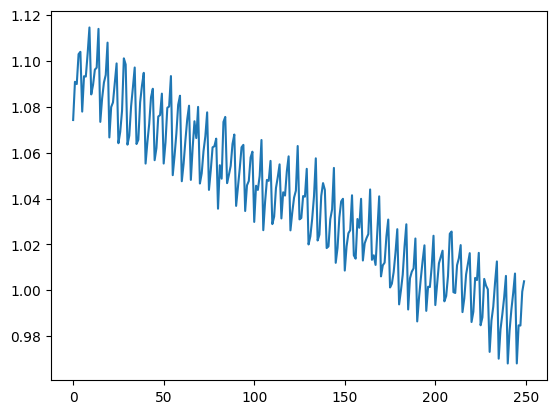

In [42]:
plt.plot(lossi[:])

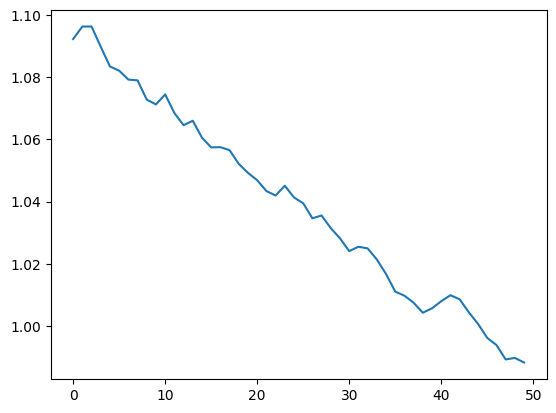

In [43]:
plt.plot(epoch_lossi)

In [37]:
epoch_lossi[-1]

0.988180410861969

In [ ]:
# Sampling example
txt = """LORD STANLEY:
Let me but meet you, ladies,"""
generated_text = model.genecxrate(".",Tokenizer,500,context_size=150)
print("Generated text:\n", generated_text)


Generated text:
 .

JULIET:
A chaes, I make lies upon me gain,
Not ne! Yones, you all confectud him:
Who may answer'd; I know my heart
Some half: be most upon my lord Grey.
Some hot it is proceed's waigher:
And as it is on myself in this feat; for or very like
What cour brother such 'cadtness.

HASTINGS:
He cannot love it cleas he comes together, a taruonder
O' the warden else be mine.
So, say the noises and Flance there comes by her kinds,
CountenNLike him of sound
Hath had lie my puper ignor, relish'd.

PERDITA:
O love!

ANGELO:
For I will revenges Warigains.

SEBASTIAN:
'Shall be a lower him from ou so.

LUCIO:
I had, beseech you, love; h


In [40]:
txt = """Nurse:
Ay, if I thy give sweetly sweet and country
us! to I make enjoiced the complaint wized myself
your reportune, and what you are to do not paise but yours:
You so heaven and all together tords yourself Joves grown,
His sin answan is importance. I beseech you to have
I pleffend me to be: ah, good Kather,
Farewell; foolies well; be bold, if you'rs cold,
Which protectors, or only grief, are head
Host-looks looker; for't prothest; as thou well a'
That courtiest you play your hearts.

TYBALLT:
Marry, you were he bewell answer.

KING RICHARD II:
Sly, we are Plantaguent, leve in Stanly long.

BUCKINGHAM:
Why, thou setst by this gentleman,
The Eart night's body more are time by-hanging,
Than well repenting her butterings took for from
From London was thence snot--bald by them but a paer;
Nerry, came by thy numbery.
Readed and gentle roan to his glorand.

RICHARD:
No, I:
Daughter, do you no denier: 'tis not thither
"""
generated_text1 = model.generate(txt,Tokenizer,1000,150)



In [ ]:
open('MultiLSTM02.txt', 'w').write(generated_text1)

2197